<a href="https://colab.research.google.com/github/looopic/ML2Project/blob/main/ML2Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visual text recognition model by Carlo Huser (husercar@students.zhaw.ch)


This model is used to extract the ingredients from an image of groceries. I want to use this model to build an app to detect allergies or intolerances on specific ingredients.

# Data
I was thinking of making my own dataset for this problem, but I quickly found out, that it's too time consuming to annotate every single picture on my own.
Therefore I searched the internet for a dataset I could use and found the TextOCR dataset on kaggle (https://www.kaggle.com/datasets/robikscube/textocr-text-extraction-from-images-dataset?select=annot.csv)

Please use one of the two options below to download the dataset to the /content-folder. For the kaggle-option, you need to download your api-json first.

In [ ]:
!gdown 1zg0ofaVhgnJQ4bmfLeo5MG1iAtoT2HnO
!unzip OCR_data.zip

In [1]:
# upload your kaggle api json-file
from google.colab import files
files.upload()

!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json



!kaggle datasets download -d robikscube/textocr-text-extraction-from-images-dataset
!unzip textocr-text-extraction-from-images-dataset.zip


Streaming output truncated to the last 5000 lines.
  inflating: train_val_images/train_images/c1309467624becbc.jpg  
  inflating: train_val_images/train_images/c13105d1fd4e7af1.jpg  
  inflating: train_val_images/train_images/c1325fb75c01f67f.jpg  
  inflating: train_val_images/train_images/c134cbbeb23c9335.jpg  
  inflating: train_val_images/train_images/c1350e9e16d99a84.jpg  
  inflating: train_val_images/train_images/c1379240b5678891.jpg  
  inflating: train_val_images/train_images/c13f76726b7d57a2.jpg  
  inflating: train_val_images/train_images/c1419c127622b8ae.jpg  
  inflating: train_val_images/train_images/c155243d8248c58e.jpg  
  inflating: train_val_images/train_images/c157a397f684fe47.jpg  
  inflating: train_val_images/train_images/c15a80746217567a.jpg  
  inflating: train_val_images/train_images/c16078bf76cd6f0d.jpg  
  inflating: train_val_images/train_images/c161e6fd35f8e369.jpg  
  inflating: train_val_images/train_images/c164bd4358945dc8.jpg  
  inflating: train_val_im

# Preprocess Images

Due to the images being real photographs, there are multiple words on each image. I need to extract those words on their own, so that i can label that word.

ATTENTION! The whole preprocessing can last up to 10 hours! You can interrupt the preprocessing earlier if you want to.

In [1]:
import os
import csv
import cv2
import numpy as np
import math
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

In [2]:
def roundup(x):
    return int(math.ceil(x / 10.0)) * 10

In [3]:
def preprocess(img):
	old_h,old_w=img.shape[0],img.shape[1]
  
	#Pad the height.
	#If height is less than 512 then pad to 512
	if old_h<512:
		to_pad=np.ones((512-old_h,old_w,3))*255
		img=np.concatenate((img,to_pad))
		new_height=512
	else:
	#If height >512 then pad to nearest 10.
		to_pad=np.ones((roundup(old_h)-old_h,old_w,3))*255
		img=np.concatenate((img,to_pad))
		new_height=roundup(old_h)

	#Pad the width.
	if old_w<512:
		to_pad=np.ones((new_height,512-old_w,3))*255
		img=np.concatenate((img,to_pad),axis=1)
		new_width=512
	else:
		to_pad=np.ones((new_height,roundup(old_w)-old_w,3))*255
		img=np.concatenate((img,to_pad),axis=1)
		new_width=roundup(old_w)-old_w
	return img

In [4]:
# initialize arrays to store data and labels
images = []
labels = []

num_iterations = 2048

# Create directories to store the images
image_dir = '/content/preprocessed_images/'
os.makedirs(image_dir, exist_ok=True)

# remove all pictures in preprocessed
image_dir = '/content/preprocessed_images/'
file_list = os.listdir(image_dir)
for file_name in file_list:
    file_path = os.path.join(image_dir, file_name)
    os.remove(file_path)

# read annotations csv file
with open('/content/annot.csv','r') as csvfile:
  reader = csv.reader(csvfile)
  
  #skip header
  next(reader)

  iterations = 0

  for row in tqdm(reader):
    image_path = "/content/train_val_images/train_images/"+row[2]+".jpg"
    boundary = row[5].strip('[]').split(',')
    boundaryArray = [float(value) for value in boundary]
    boundaryXmin = int(min(boundaryArray[0], boundaryArray[2], boundaryArray[4], boundaryArray[6]))
    boundaryXmax = int(max(boundaryArray[0], boundaryArray[2], boundaryArray[4], boundaryArray[6]))
    boundaryYmin = int(min(boundaryArray[1], boundaryArray[3], boundaryArray[5], boundaryArray[7]))
    boundaryYmax = int(max(boundaryArray[1], boundaryArray[3], boundaryArray[5], boundaryArray[7]))
    text = row[4]
    name = row[0]

    #load image
    image = cv2.imread(image_path)

    #extract text region
    text_region = image[boundaryYmin:boundaryYmax, boundaryXmin:boundaryXmax]

    #preprocess text region
    text_region = preprocess(text_region)

    # Generate a unique filename for each image
    image_filename = f"{name}.jpg"

    # Save the preprocessed image to disk
    image_path = os.path.join(image_dir, image_filename)
    cv2.imwrite(image_path, text_region)

    #append data to arrays
    images.append(image_filename)
    labels.append(text)

    iterations += 1

    if iterations == num_iterations:
            break


2047it [01:33, 21.87it/s]


In [5]:
#encode labels to numerical values
label_encoder = LabelEncoder()
label_encoder.fit(labels)
encoded_labels = label_encoder.transform(labels)

# Model

I'm following the tutorial on medium.com (https://medium.com/geekculture/building-a-complete-ocr-engine-from-scratch-in-python-be1fd184753b)
But due to my data not being compiled the same as the data this tutorial uses, I had to adjust practically the whole data preprocessing.

In [6]:
from keras.layers import *
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
import random
import tensorflow as tf
import gc

In [7]:
batch_size = 16

random_indices = np.arange(len(images))
num_samples = len(images)
num_batches = num_samples // batch_size
num_samples = num_batches * batch_size
random_indices = random_indices[:num_samples]
np.random.shuffle(random_indices)
training_indices=random_indices[0:int(0.9*len(random_indices))]
test_indices=random_indices[int(0.9*len(random_indices)):]
#X_test = []
#for filename in images[test_indices]:
#  img=cv2.imread(f'/content/preprocessed_images/{fn}.jpg',0)
#  X_test.append(img)
#y_test = encoded_labels[test_indices]

def batch_generator(indices, images, encoded_labels, batch_size):
    while True:
        X = []
        Y = []
        for i in range(batch_size):
            index = random.choice(indices)
            fn = images[index]
            img = cv2.imread(f'/content/preprocessed_images/{fn}', cv2.IMREAD_COLOR)
            label = encoded_labels[index]
            X.append(img)
            Y.append(label)
            del img, label
            
        X = np.array(X)
        Y = np.array(Y)

        print(X.shape, Y.shape)

        yield X, Y


In [8]:
def unet(pretrained_weights = None,input_size = (512,512,3)):
  inputs = Input(input_size)
  conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
  conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
  conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
  conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
  conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
  drop4 = Dropout(0.5)(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

  conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
  conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
  drop5 = Dropout(0.5)(conv5)

  up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
  merge6 = concatenate([drop4,up6], axis = 3)
  conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
  conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

  up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
  merge7 = concatenate([conv3,up7], axis = 3)
  conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
  conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

  up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
  merge8 = concatenate([conv2,up8], axis = 3)
  conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
  conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

  up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
  merge9 = concatenate([conv1,up9], axis = 3)
  conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
  conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
  conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
  num_classes = len(label_encoder.classes_)
  conv10 = Conv2D(num_classes, 1, activation='softmax')(conv9)

  model = Model(inputs,conv10)

  model.compile(optimizer = Adam(learning_rate=0.001), loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics = ['accuracy'])
  
  #model.summary()

  if(pretrained_weights):
    model.load_weights(pretrained_weights)

  return model

model=unet()


mc = ModelCheckpoint('/content/checkpoints/weights{epoch:08d}.h5',save_weights_only=True, save_freq=4)
ec = EarlyStopping(patience=3, restore_best_weights=True)

In [9]:
# Create a dataset from image paths and labels
dataset = tf.data.Dataset.from_tensor_slices((images, encoded_labels))

# Define preprocessing and augmentation functions
def preprocess_fn(image_path, label):

  try:
    # Join path components
    image_path = '/content/preprocessed_images/' + image_path

    # Remove trailing '/'
    image_path = tf.strings.regex_replace(image_path, '/.jpg$', '.jpg')

    # Load and preprocess the image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3)
    
    return image, label
  except tf.errors.NotFoundError:
        # Skip the instance if the file is not found
    return None, None




# Apply preprocessing
dataset = dataset.map(preprocess_fn)
dataset = dataset.filter(lambda image, label: image is not None and label is not None)

# Shuffle and batch the dataset
dataset = dataset.shuffle(buffer_size=len(images))
dataset = dataset.batch(batch_size)

# Split into training and test datasets
train_dataset = dataset.take(int(0.9 * len(images)))
test_dataset = dataset.skip(int(0.9 * len(images)))


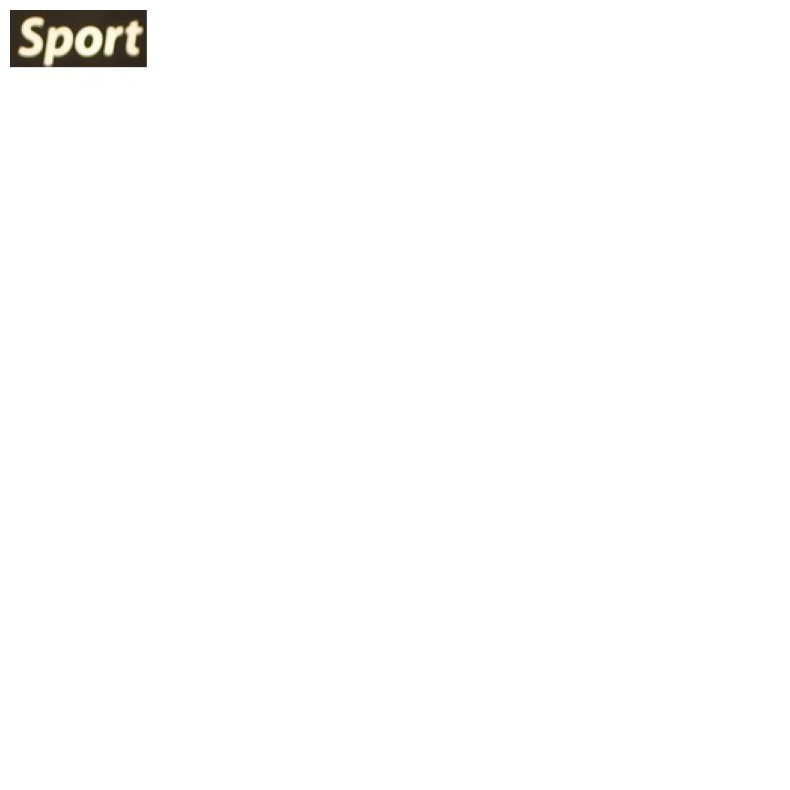

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(plt.imread("/content/preprocessed_images/1.jpg"))
ax.axis('off')
plt.show()


In [ ]:

epochs = 1
#train_generator = batch_generator(training_indices, images, encoded_labels, batch_size)
#test_generator = batch_generator(test_indices, images, encoded_labels, batch_size)

# Clear the memory after each epoch
def clear_memory():
    del train_generator
    del test_generator
    gc.collect()
    tf.keras.backend.clear_session()

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    
    # Train the model
    model.fit(
        train_dataset,
        epochs=epochs,
        validation_data=test_dataset,
        callbacks=[mc, ec]
    )

    # Clear the memory
    clear_memory()


#model.evaluate(X_test, y_test)
model.save('/content/ocr_model.h5')

Epoch 1/1


# Evaluation and Comparision